In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Combined Training Script (Comprehensive)
Includes:
- EDA and Data Loading
- Feature Extraction (Color Histograms)
- ML Baselines (LR, RF, GB)
- Deep Learning (ResNet50 with Transfer Learning)
- ROC AUC Analysis
- Comprehensive Model Saving
- Disease Recommendations
"""

'\nCombined Training Script (Comprehensive)\nIncludes:\n- EDA and Data Loading\n- Feature Extraction (Color Histograms)\n- ML Baselines (LR, RF, GB)\n- Deep Learning (ResNet50 with Transfer Learning)\n- ROC AUC Analysis\n- Comprehensive Model Saving\n- Disease Recommendations\n'

Core libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings
import pickle
import json
from datetime import datetime
import ssl
import certifi

Set SSL cert for Mac

In [3]:
os.environ['SSL_CERT_FILE'] = certifi.where()

In [4]:
warnings.filterwarnings('ignore')

Image processing

In [5]:
from PIL import Image
import cv2
from skimage import feature

Machine Learning

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.utils import class_weight

Deep Learning

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [9]:
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPU Available: []


Configuration

In [10]:
CONFIG = {
    'DATASET_PATH': '/Users/rohithpavan/Desktop/SL Dataset',
    'IMG_SIZE': (224, 224),  
    'BATCH_SIZE': 32,
    'EPOCHS': 50,
    'RANDOM_STATE': 42,
    'TEST_SIZE': 0.15,
    'VAL_SIZE': 0.15,
    'N_CLASSES': None
}

Set random seeds

In [11]:
np.random.seed(CONFIG['RANDOM_STATE'])
tf.random.set_seed(CONFIG['RANDOM_STATE'])

Create directories

In [12]:
os.makedirs('saved_models', exist_ok=True)
os.makedirs('plots', exist_ok=True)

In [13]:
print("✓ Configuration loaded!")
print(f"Dataset path: {CONFIG['DATASET_PATH']}")

✓ Configuration loaded!
Dataset path: /Users/rohithpavan/Desktop/SL Dataset


In [14]:
def load_dataset_structure(dataset_path):
    """Load and analyze dataset structure"""
    dataset_path = Path(dataset_path)
    
    # Check if train/test split exists
    if (dataset_path / 'train').exists():
        train_path = dataset_path / 'train'
        test_path = dataset_path / 'test' if (dataset_path / 'test').exists() else None
    else:
        train_path = dataset_path
        test_path = None
    
    # Get all class folders
    classes = sorted([d.name for d in train_path.iterdir() if d.is_dir()])
    
    # Count images per class and filter small classes (ensuring enough for split)
    class_counts = {}
    valid_classes = []
    for class_name in classes:
        class_path = train_path / class_name
        images = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png')) + list(class_path.glob('*.jpeg'))
        count = len(images)
        if count >= 5:
            valid_classes.append(class_name)
            class_counts[class_name] = count
        else:
            print(f"Warning: Class '{class_name}' has only {count} images. Excluding from training.")
            
    CONFIG['N_CLASSES'] = len(valid_classes)
    classes = sorted(valid_classes) # Ensure sorted order
    
    print(f"✓ Found {len(classes)} valid classes")
    print(f"✓ Total images: {sum(class_counts.values())}")
    print(f"\nClass distribution:")
    for cls in classes[:10]:
         print(f"  {cls}: {class_counts[cls]} images")
    
    return train_path, test_path, classes, class_counts

In [15]:
def load_images_and_labels(data_path, classes, img_size=(224, 224), max_images_per_class=None):
    """Load all images and labels"""
    images = []
    labels = []
    
    print("Loading images...")
    for class_idx, class_name in enumerate(classes):
        class_path = Path(data_path) / class_name
        image_files = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png')) + list(class_path.glob('*.jpeg'))
        
        if max_images_per_class:
            image_files = image_files[:max_images_per_class]
        
        for img_file in image_files:
            try:
                img = Image.open(img_file).convert('RGB')
                img = img.resize(img_size)
                img_array = np.array(img)
                images.append(img_array)
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_file}: {e}")
        
        if (class_idx + 1) % 5 == 0:
            print(f"  Processed {class_idx + 1}/{len(classes)} classes...")
    
    return np.array(images), np.array(labels)

In [16]:
def extract_features(images):
    """Extract color histogram features"""
    features = []
    
    print("Extracting features (Color Histograms)...")
    for i, img in enumerate(images):
        # Color histograms (32 bins per channel)
        hist_r = np.histogram(img[:, :, 0], bins=32, range=(0, 256))[0]
        hist_g = np.histogram(img[:, :, 1], bins=32, range=(0, 256))[0]
        hist_b = np.histogram(img[:, :, 2], bins=32, range=(0, 256))[0]
        
        # Normalize
        color_features = np.concatenate([hist_r, hist_g, hist_b])
        color_features = color_features / (img.shape[0] * img.shape[1])
        
        features.append(color_features)
        
        if (i + 1) % 1000 == 0:
            print(f"  Processed {i + 1}/{len(images)} images")
    
    return np.array(features)

In [17]:
def plot_roc_curves(y_test, y_score, classes, title='ROC Curve', filename='roc_curve.png'):
    """Plot ROC curves for multi-class"""
    # Binarize the output
    y_test_bin = label_binarize(y_test, classes=range(len(classes)))
    n_classes = y_test_bin.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    
    colors = plt.cm.viridis(np.linspace(0, 1, n_classes))
    for i, color in zip(range(min(n_classes, 10)), colors): # Limit to 10 classes for clarity
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right", fontsize='small')
    plt.savefig(f'plots/{filename}')
    plt.show()
    plt.close()
    
    return roc_auc["micro"]

In [19]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', filename='confusion_matrix.png'):
    """Plot Confusion Matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=13, fontweight='bold')
    plt.ylabel('True Label', fontsize=11)
    plt.xlabel('Predicted Label', fontsize=11)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.savefig(f'plots/{filename}')
    plt.show()
    plt.close()

In [21]:
def plot_samples(X, y, classes, samples_per_class=5):
    n_classes = min(len(classes), 10)  # Show max 10 classes
    fig, axes = plt.subplots(n_classes, samples_per_class, figsize=(15, 3*n_classes))
    
    for class_idx in range(n_classes):
        class_images = X[y == class_idx]
        n_available = min(samples_per_class, len(class_images))
        if n_available == 0: continue
        sample_indices = np.random.choice(len(class_images), n_available, replace=False)
        
        for i in range(samples_per_class):
            ax = axes[class_idx, i] if n_classes > 1 else axes[i]
            if i < n_available:
                ax.imshow(class_images[sample_indices[i]].astype('uint8'))
                ax.axis('off')
                if i == 0:
                    ax.text(-10, class_images[0].shape[0]//2, classes[class_idx], 
                           rotation=90, va='center', fontsize=10, fontweight='bold')
            else:
                ax.axis('off')
    
    plt.suptitle('Sample Images from Each Class', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

==================================================================================<br>
MAIN EXECUTION<br>
==================================================================================

1. Load Data

In [22]:
train_path, test_path, classes, class_counts = load_dataset_structure(CONFIG['DATASET_PATH'])
X, y = load_images_and_labels(train_path, classes, CONFIG['IMG_SIZE'])

✓ Found 42 valid classes
✓ Total images: 11719

Class distribution:
  American Bollworm on Cotton: 56 images
  Anthracnose on Cotton: 29 images
  Army worm: 40 images
  Becterial Blight in Rice: 1326 images
  Brownspot: 1623 images
  Common_Rust: 114 images
  Cotton Aphid: 39 images
  Flag Smut: 179 images
  Gray_Leaf_Spot: 128 images
  Healthy Maize: 1141 images
Loading images...
  Processed 5/42 classes...
  Processed 10/42 classes...
  Processed 15/42 classes...
  Processed 20/42 classes...
  Processed 25/42 classes...
  Processed 30/42 classes...
  Processed 35/42 classes...
  Processed 40/42 classes...


In [23]:
print(f"\n✓ Dataset shape: {X.shape}")
print(f"✓ Labels shape: {y.shape}")
print(f"✓ Memory usage: {X.nbytes / (1024**3):.2f} GB")


✓ Dataset shape: (11719, 224, 224, 3)
✓ Labels shape: (11719,)
✓ Memory usage: 1.64 GB


2. Split Data<br>
Stratified split

In [24]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=CONFIG['TEST_SIZE'], 
    stratify=y, random_state=CONFIG['RANDOM_STATE']
)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=CONFIG['VAL_SIZE']/(1-CONFIG['TEST_SIZE']), 
    stratify=y_temp, 
    random_state=CONFIG['RANDOM_STATE']
)

In [26]:
print(f"Train set: {X_train.shape[0]} images ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} images ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} images ({len(X_test)/len(X)*100:.1f}%)")

Train set: 8203 images (70.0%)
Validation set: 1758 images (15.0%)
Test set: 1758 images (15.0%)


Normalize to [0, 1] for ML models - Features will be extracted from raw or normalized?<br>
extract_features uses raw images (0-255).<br>
ResNet50 uses its own preprocess_input.<br>
So we keep X_train as is for now, and handle normalization where needed.

3. EDA<br>
EDA 1: Class Distribution

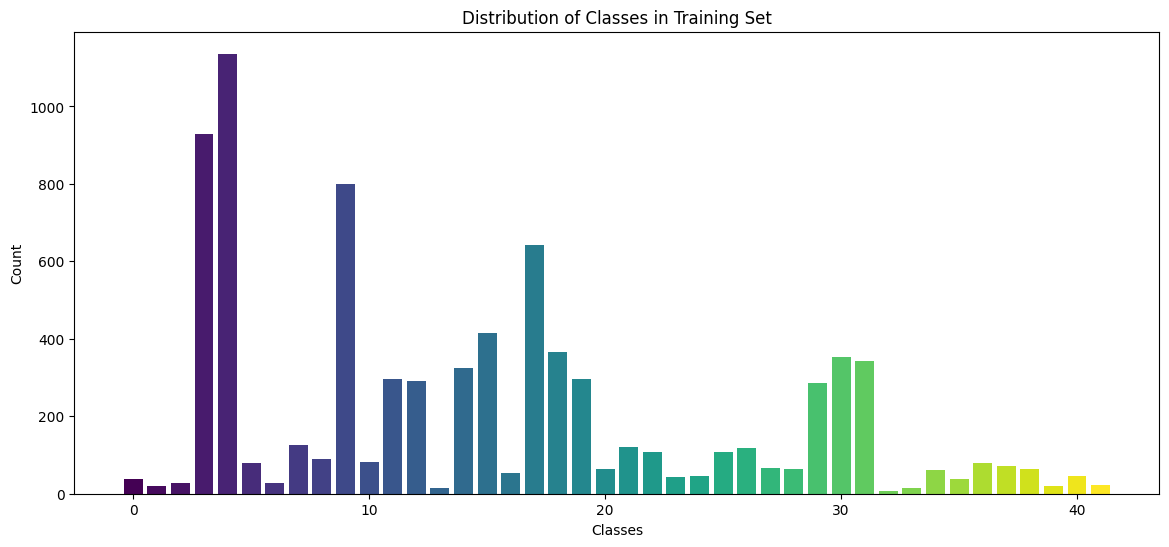

In [28]:
plt.figure(figsize=(14, 6))
unique, counts = np.unique(y_train, return_counts=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique)))
plt.bar(unique, counts, color=colors)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Distribution of Classes in Training Set')
plt.show()

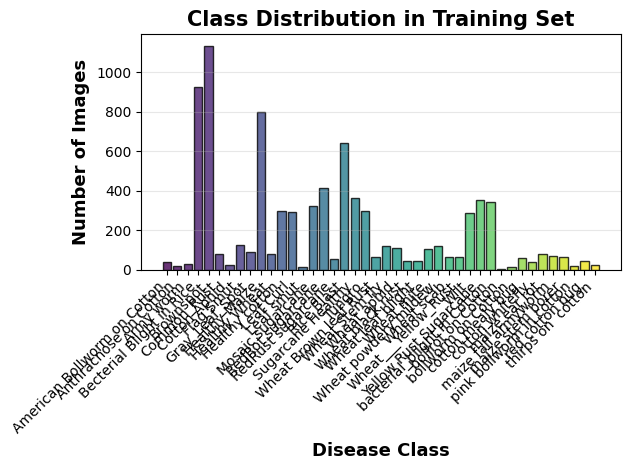

In [29]:
plt.bar([classes[i] for i in unique], counts, color=colors, edgecolor='black', alpha=0.8)
plt.xlabel('Disease Class', fontsize=13, fontweight='bold')
plt.ylabel('Number of Images', fontsize=13, fontweight='bold')
plt.title('Class Distribution in Training Set', fontsize=15, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('plots/class_distribution.png')
plt.show()
plt.close()

EDA 2: Sample Visualization

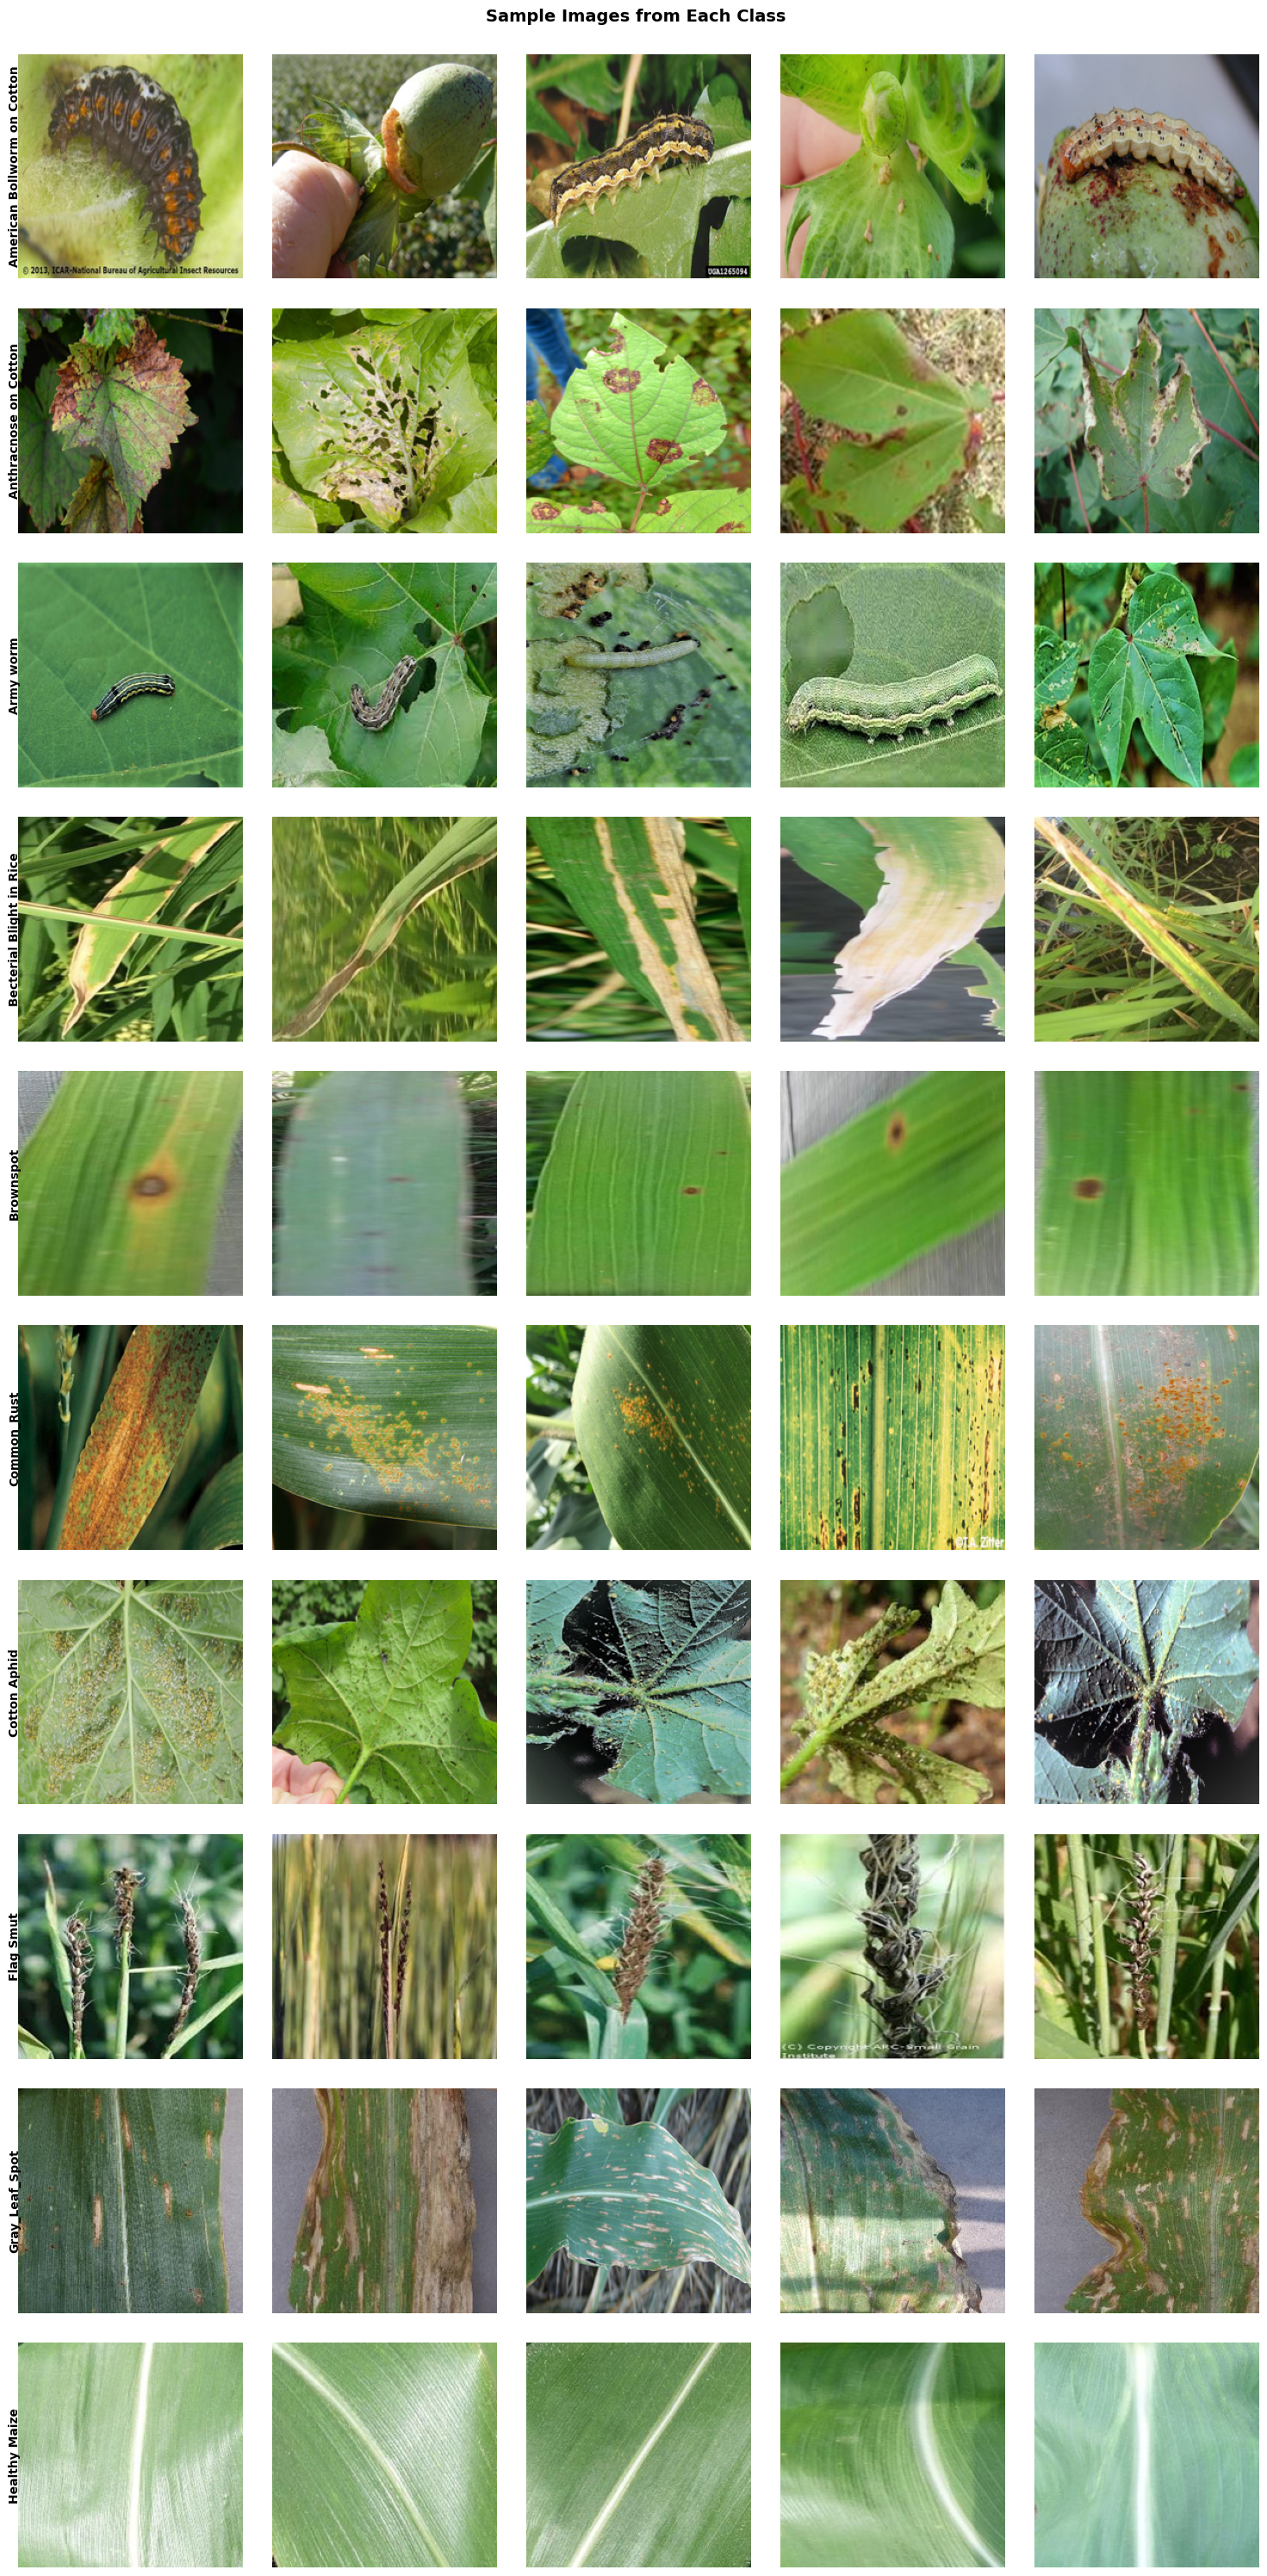

In [30]:
plot_samples(X_train, y_train, classes)

EDA 3: Image Statistics

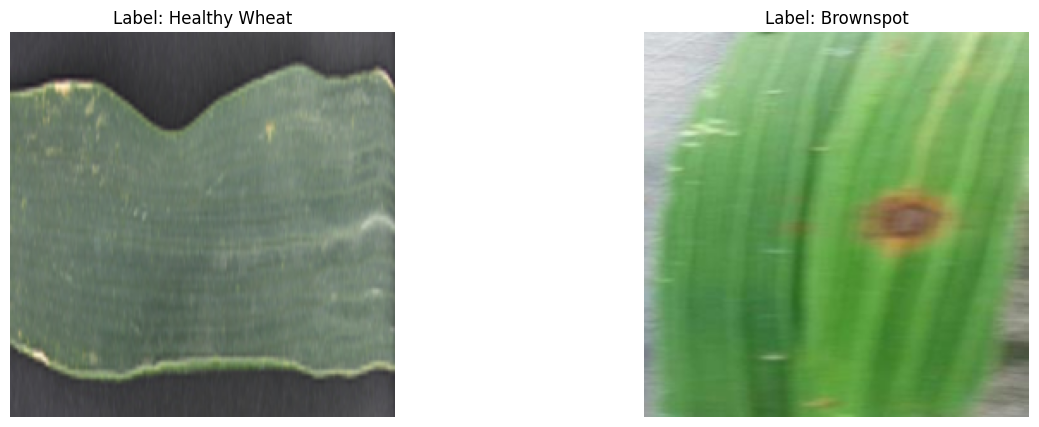

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(X_train[0])
axes[0].set_title(f"Label: {classes[y_train[0]]}")
axes[0].axis('off')
axes[1].imshow(X_test[0])
axes[1].set_title(f"Label: {classes[y_test[0]]}")
axes[1].axis('off')
plt.show()

Brightness per class

In [33]:
brightness_per_class = []
for class_idx in range(len(classes)):
    class_images = X_train[y_train == class_idx]
    if len(class_images) > 0:
        brightness = np.mean(class_images, axis=(1, 2, 3))
        brightness_per_class.append(brightness)
    else:
        brightness_per_class.append([])

In [34]:
bp = axes[0].boxplot(brightness_per_class, labels=classes, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[0].set_xlabel('Class', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Average Brightness', fontsize=11, fontweight='bold')
axes[0].set_title('Brightness Distribution by Class', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

RGB histograms

In [35]:
for class_idx in range(min(3, len(classes))):
    class_images = X_train[y_train == class_idx]
    if len(class_images) > 0:
        sample_img = class_images[np.random.randint(len(class_images))]
        
        for channel, color in enumerate(['red', 'green', 'blue']):
            axes[1].hist(sample_img[:, :, channel].flatten(), bins=50, 
                        alpha=0.4, label=f'{classes[class_idx]}-{color}', color=color)

In [36]:
axes[1].set_xlabel('Pixel Value', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1].set_title('RGB Channel Distribution (Sample Images)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=8)
axes[1].grid(alpha=0.3)

In [ ]:
plt.tight_layout()
plt.show()
plt.close()

<Figure size 640x480 with 0 Axes>

==================================================================================<br>
PART 1: MACHINE LEARNING BASELINES (Color Histograms)<br>
==================================================================================

In [38]:
print("\n" + "="*70)
print("PART 1: MACHINE LEARNING BASELINES (Color Histograms)")
print("="*70)


PART 1: MACHINE LEARNING BASELINES (Color Histograms)


Extract features

In [39]:
X_train_feat = extract_features(X_train)
X_val_feat = extract_features(X_val)
X_test_feat = extract_features(X_test)

Extracting features (Color Histograms)...
  Processed 1000/8203 images
  Processed 2000/8203 images
  Processed 3000/8203 images
  Processed 4000/8203 images
  Processed 5000/8203 images
  Processed 6000/8203 images
  Processed 7000/8203 images
  Processed 8000/8203 images
Extracting features (Color Histograms)...
  Processed 1000/1758 images
Extracting features (Color Histograms)...
  Processed 1000/1758 images


Standardize

In [40]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_val_scaled = scaler.transform(X_val_feat)
X_test_scaled = scaler.transform(X_test_feat)

In [41]:
print(f"\n✓ Feature shape: {X_train_scaled.shape}")


✓ Feature shape: (8203, 96)


A. Logistic Regression

In [42]:
print("\nBASELINE MODEL 1: LOGISTIC REGRESSION")
lr_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    C=1.0,
    class_weight='balanced',
    random_state=CONFIG['RANDOM_STATE'],
    verbose=1
)
lr_model.fit(X_train_scaled, y_train)
train_acc_lr = accuracy_score(y_train, lr_model.predict(X_train_scaled))
y_val_pred_lr = lr_model.predict(X_val_scaled)
val_acc_lr = accuracy_score(y_val, y_val_pred_lr)
print(f"✓ LR Training Accuracy: {train_acc_lr:.4f}")
print(f"✓ LR Validation Accuracy: {val_acc_lr:.4f}")


BASELINE MODEL 1: LOGISTIC REGRESSION
✓ LR Training Accuracy: 0.5274
✓ LR Validation Accuracy: 0.4516


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


Plot Confusion Matrix LR

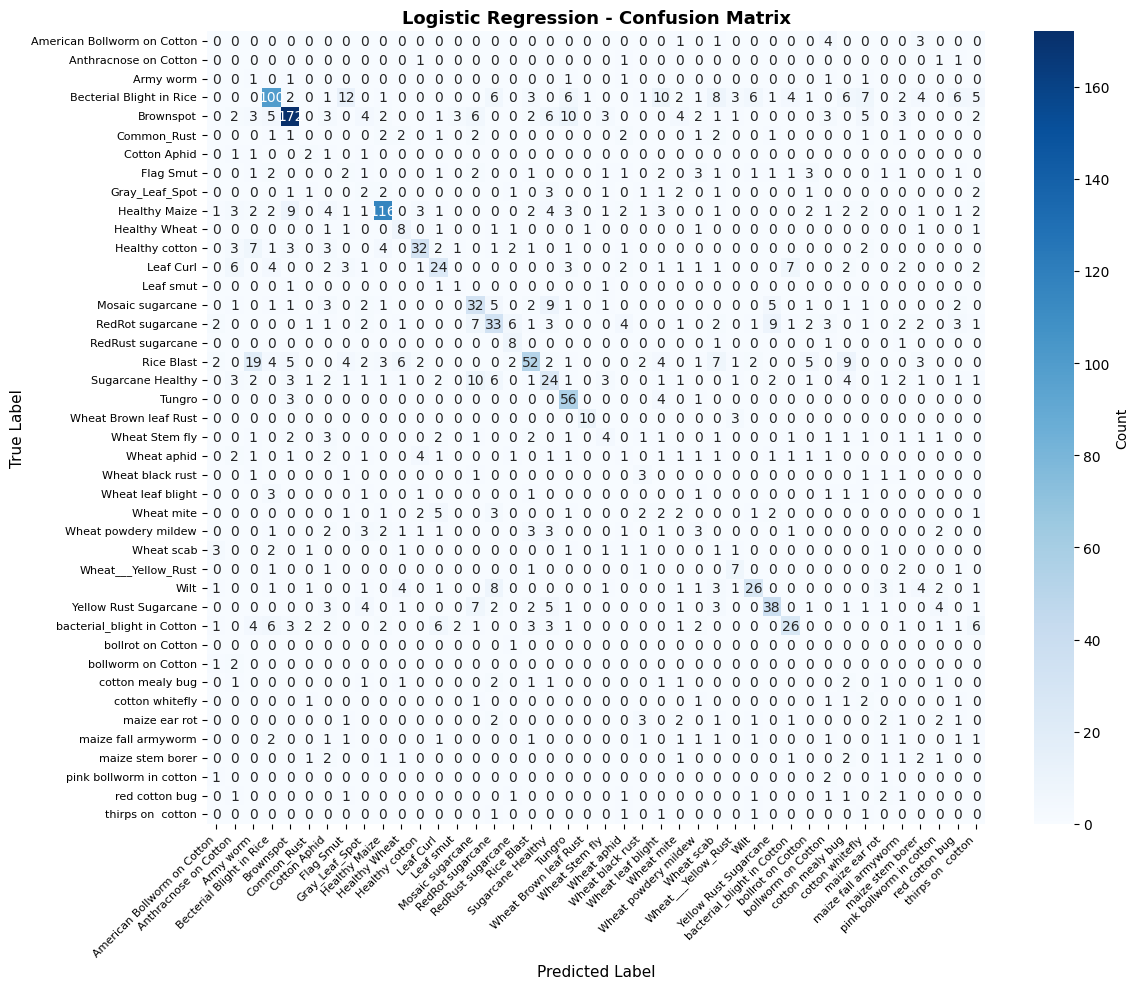

In [43]:
plot_confusion_matrix(y_val, y_val_pred_lr, classes, title='Logistic Regression - Confusion Matrix', filename='confusion_matrix_lr.png')

B. Random Forest

In [44]:
print("\nBASELINE MODEL 2: RANDOM FOREST")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    class_weight='balanced',
    random_state=CONFIG['RANDOM_STATE'],
    n_jobs=-1,
    verbose=1
)
rf_model.fit(X_train_scaled, y_train)
train_acc_rf = accuracy_score(y_train, rf_model.predict(X_train_scaled))
y_val_pred_rf = rf_model.predict(X_val_scaled)
val_acc_rf = accuracy_score(y_val, y_val_pred_rf)
print(f"✓ RF Training Accuracy: {train_acc_rf:.4f}")
print(f"✓ RF Validation Accuracy: {val_acc_rf:.4f}")


BASELINE MODEL 2: RANDOM FOREST


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s


✓ RF Training Accuracy: 0.9983
✓ RF Validation Accuracy: 0.8072


[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.1s finished


Plot Confusion Matrix RF

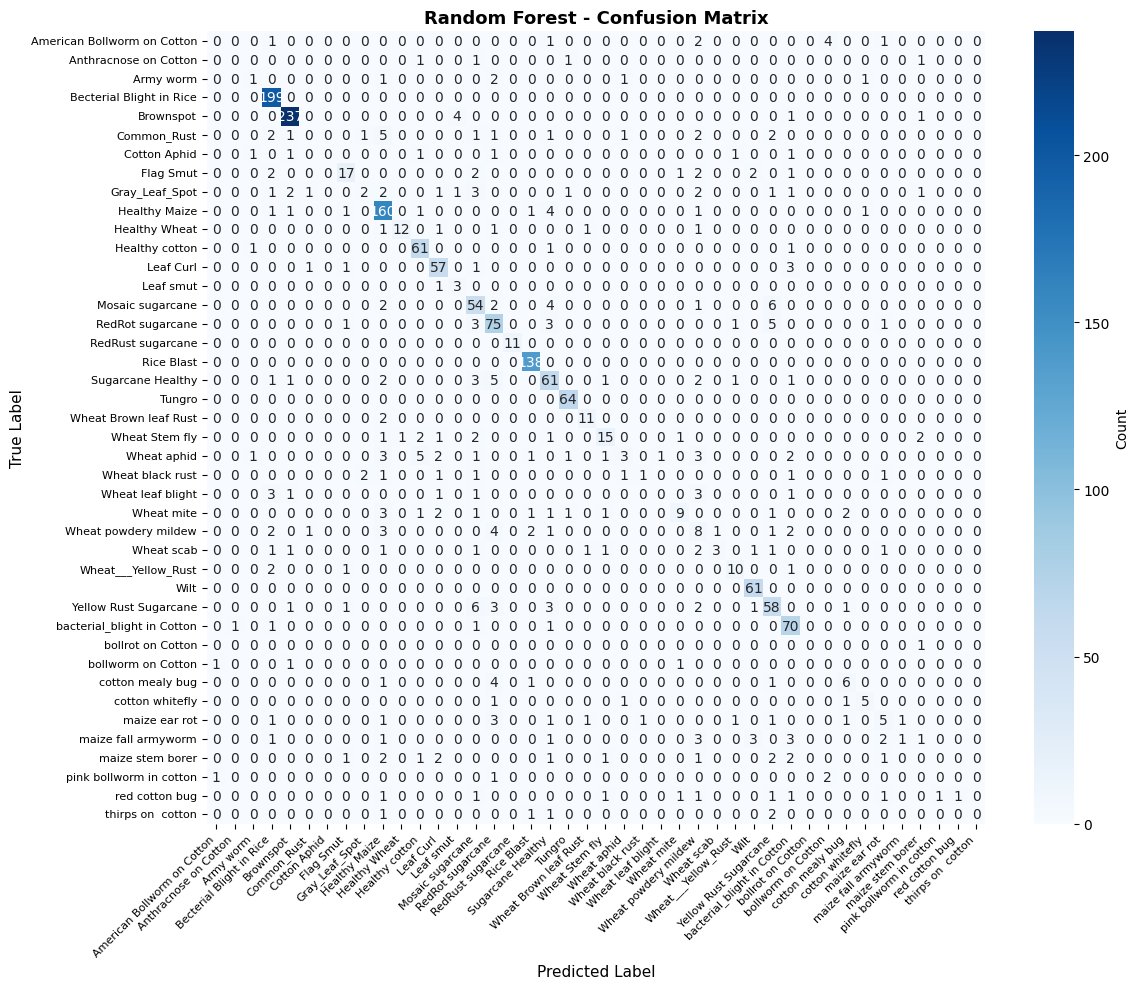

In [45]:
plot_confusion_matrix(y_val, y_val_pred_rf, classes, title='Random Forest - Confusion Matrix', filename='confusion_matrix_rf.png')

C. Gradient Boosting

In [46]:
print("\nBASELINE MODEL 3: GRADIENT BOOSTING")
gb_model = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5,
    random_state=CONFIG['RANDOM_STATE'],
    verbose=1
)
gb_model.fit(X_train_scaled, y_train)
train_acc_gb = accuracy_score(y_train, gb_model.predict(X_train_scaled))
y_val_pred_gb = gb_model.predict(X_val_scaled)
val_acc_gb = accuracy_score(y_val, y_val_pred_gb)
print(f"✓ GB Training Accuracy: {train_acc_gb:.4f}")
print(f"✓ GB Validation Accuracy: {val_acc_gb:.4f}")


BASELINE MODEL 3: GRADIENT BOOSTING
      Iter       Train Loss   Remaining Time 
         1           2.2601           19.78m
         2        4853.7002           20.02m
         3      300907.2097           20.02m
         4      300906.9889           19.95m
         5      300906.8232           19.87m
         6      300906.6919           19.79m
         7      300931.2860           19.67m
         8      300931.1739           19.55m
         9      300931.2822           19.43m
        10      300931.2099           19.31m
        20      300929.5120           17.96m
        30      300929.3789           16.58m
        40      300929.3186           15.20m
        50      300929.2872           13.82m
        60      300929.2693           12.44m
        70      300929.2588           11.06m
        80      300929.2526            9.69m
        90      300929.2487            8.31m
       100      300929.2457            6.93m
✓ GB Training Accuracy: 0.9965
✓ GB Validation Accuracy: 0.775

Plot Confusion Matrix GB

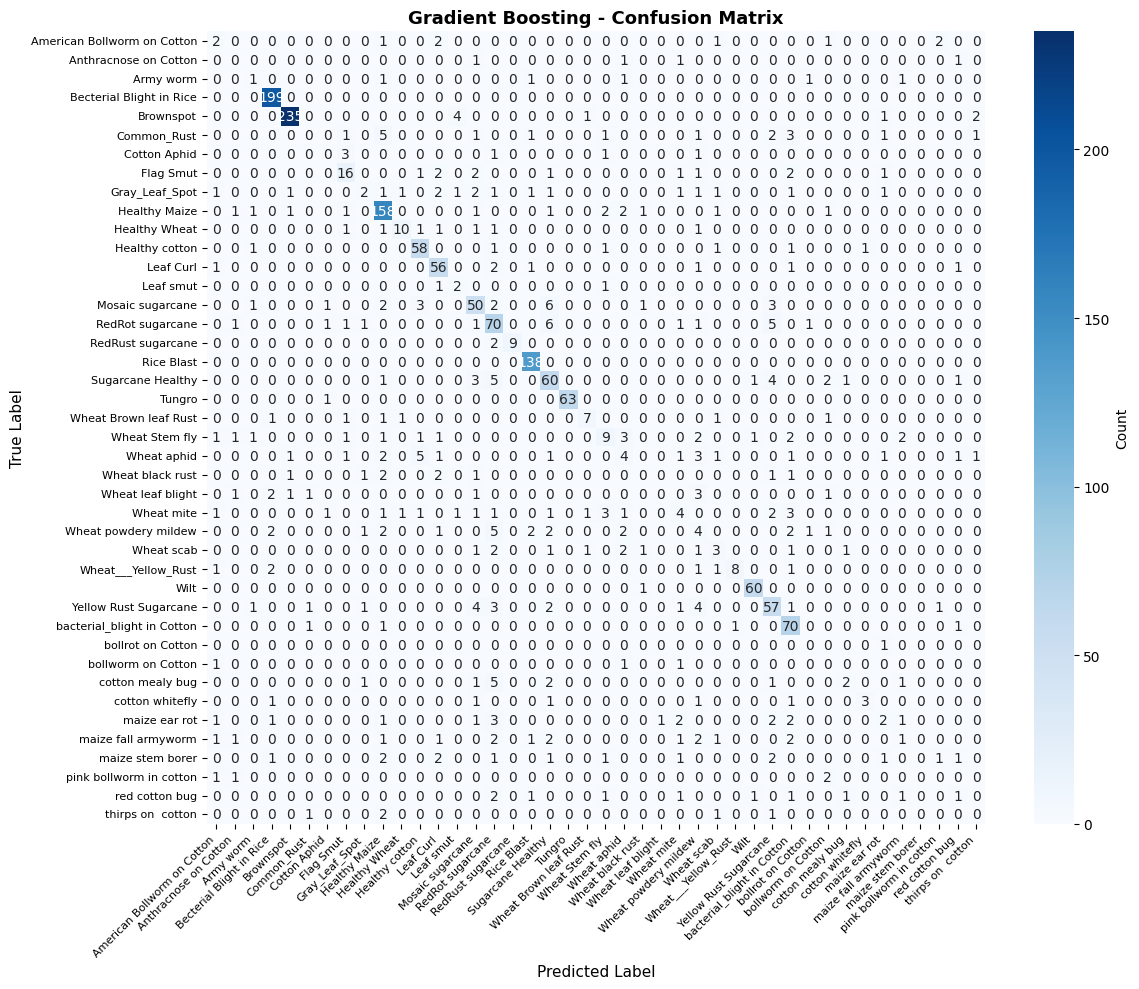

In [47]:
plot_confusion_matrix(y_val, y_val_pred_gb, classes, title='Gradient Boosting - Confusion Matrix', filename='confusion_matrix_gb.png')

Compare Baselines

In [48]:
baseline_results = {
    'Logistic Regression': val_acc_lr,
    'Random Forest': val_acc_rf,
    'Gradient Boosting': val_acc_gb
}
print("\n" + "="*70)
print("BASELINE MODEL COMPARISON")
print("="*70)
for model, acc in baseline_results.items():
    print(f"{model:25s}: {acc:.4f} ({acc*100:.2f}%)")


BASELINE MODEL COMPARISON
Logistic Regression      : 0.4516 (45.16%)
Random Forest            : 0.8072 (80.72%)
Gradient Boosting        : 0.7759 (77.59%)


In [52]:
plt.figure(figsize=(10, 6))
models_plot = list(baseline_results.keys())
accuracies_plot = list(baseline_results.values())
colors_plot = ['#3498db', '#2ecc71', '#e67e22']

<Figure size 1000x600 with 0 Axes>

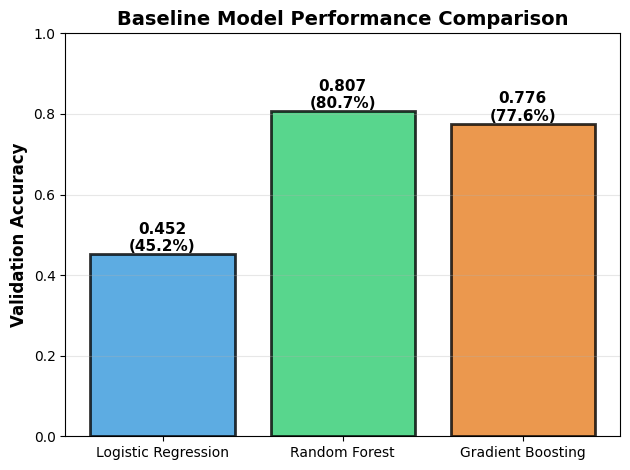

In [51]:
bars = plt.bar(models_plot, accuracies_plot, color=colors_plot, edgecolor='black', linewidth=2, alpha=0.8)
plt.ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
plt.title('Baseline Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}\n({height*100:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()
plt.close()

==================================================================================<br>
PART 2: DEEP LEARNING (ResNet50)<br>
==================================================================================

In [55]:
print("\n" + "="*70)
print("PART 2: DEEP LEARNING (ResNet50)")
print("="*70)


PART 2: DEEP LEARNING (ResNet50)


Calculate class weights

In [56]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

Data Augmentation

In [57]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

In [58]:
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

Build Model

In [59]:
print("Building ResNet50 model...")
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=CONFIG['IMG_SIZE'] + (3,))

Building ResNet50 model...


In [60]:
for layer in base_model.layers:
    layer.trainable = False

In [61]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(CONFIG['N_CLASSES'], activation='softmax')(x)

In [62]:
dl_model = Model(inputs=base_model.input, outputs=predictions)
dl_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Train

In [63]:
print("Starting ResNet50 training...")
history = dl_model.fit(
    datagen.flow(X_train, y_train, batch_size=CONFIG['BATCH_SIZE']),
    steps_per_epoch=max(1, len(X_train) // CONFIG['BATCH_SIZE']),
    epochs=CONFIG['EPOCHS'],
    validation_data=val_datagen.flow(X_val, y_val, batch_size=CONFIG['BATCH_SIZE']),
    class_weight=class_weight_dict,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True, monitor='val_accuracy'),
        ReduceLROnPlateau(factor=0.2, patience=3, monitor='val_accuracy')
    ]
)

Starting ResNet50 training...
Epoch 1/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 196s 752ms/step - accuracy: 0.4928 - loss: 2.5997 - val_accuracy: 0.7668 - val_loss: 0.8154 - learning_rate: 0.0010
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - accuracy: 0.7188 - loss: 1.3719 - val_accuracy: 0.7691 - val_loss: 0.8221 - learning_rate: 0.0010
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 198s 772ms/step - accuracy: 0.6415 - loss: 1.5410 - val_accuracy: 0.7935 - val_loss: 0.6764 - learning_rate: 0.0010
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - accuracy: 0.6562 - loss: 0.9249 - val_accuracy: 0.7924 - val_loss: 0.6831 - learning_rate: 0.0010
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 201s 784ms/step - accuracy: 0.6969 - loss: 1.2768 - val_accuracy: 0.8032 - val_loss: 0.6341 - learning_rate: 0.0010
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 36s 139ms/step - accuracy: 0.7188 - loss: 0.5182 - val_accuracy: 0.8038 - val_loss: 0.6356 - learning_rate: 0.0010
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━

Print Final Training Stats

In [64]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"✓ ResNet50 Training Accuracy (Final): {final_train_acc:.4f}")
print(f"✓ ResNet50 Validation Accuracy (Final): {final_val_acc:.4f}")

✓ ResNet50 Training Accuracy (Final): 0.9062
✓ ResNet50 Validation Accuracy (Final): 0.8936


Plot Training History

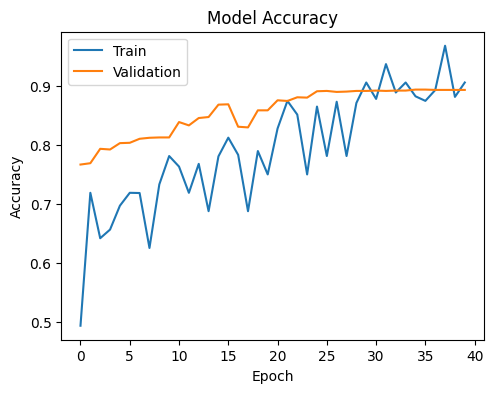

In [65]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

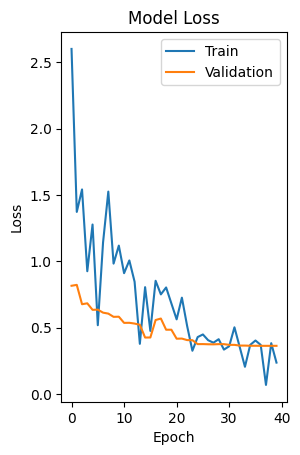

In [66]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('plots/resnet50_history.png')
plt.show()
plt.close()

Evaluation

In [67]:
print("\nEvaluating ResNet50...")
X_test_preprocessed = preprocess_input(X_test.copy().astype('float32'))
y_test_pred_prob_dl = dl_model.predict(X_test_preprocessed)
y_test_pred_dl = np.argmax(y_test_pred_prob_dl, axis=1)


Evaluating ResNet50...
55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 641ms/step


In [68]:
test_acc_dl = accuracy_score(y_test, y_test_pred_dl)
print(f"✓ ResNet50 Test Accuracy: {test_acc_dl:.4f}")

✓ ResNet50 Test Accuracy: 0.8908


ROC AUC for ResNet50

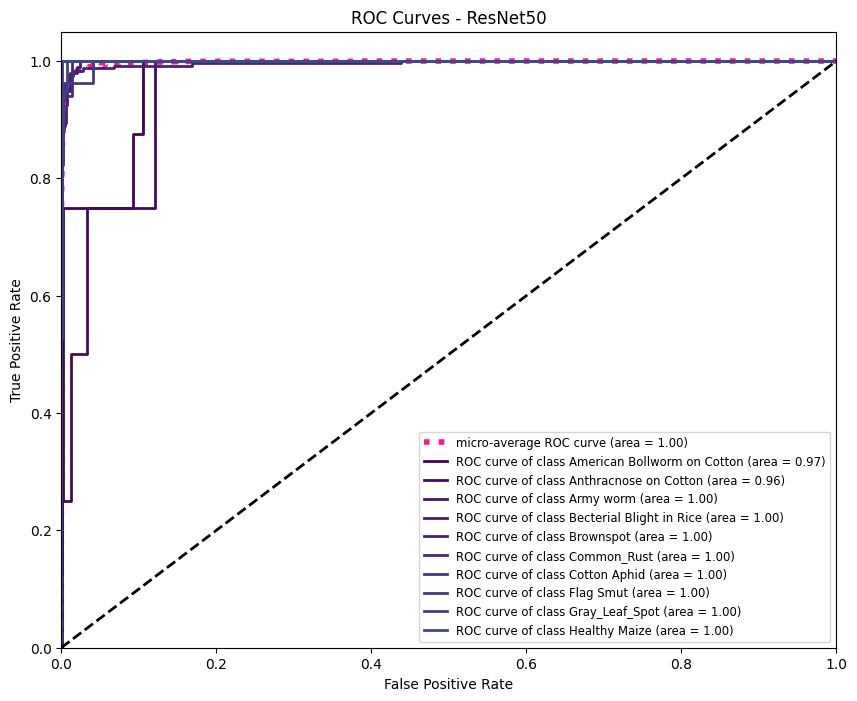

✓ ResNet50 ROC AUC (Micro): 0.9981


In [69]:
roc_auc_dl = plot_roc_curves(y_test, y_test_pred_prob_dl, classes, title='ROC Curves - ResNet50', filename='roc_curve_resnet50.png')
print(f"✓ ResNet50 ROC AUC (Micro): {roc_auc_dl:.4f}")

Confusion Matrix for ResNet50

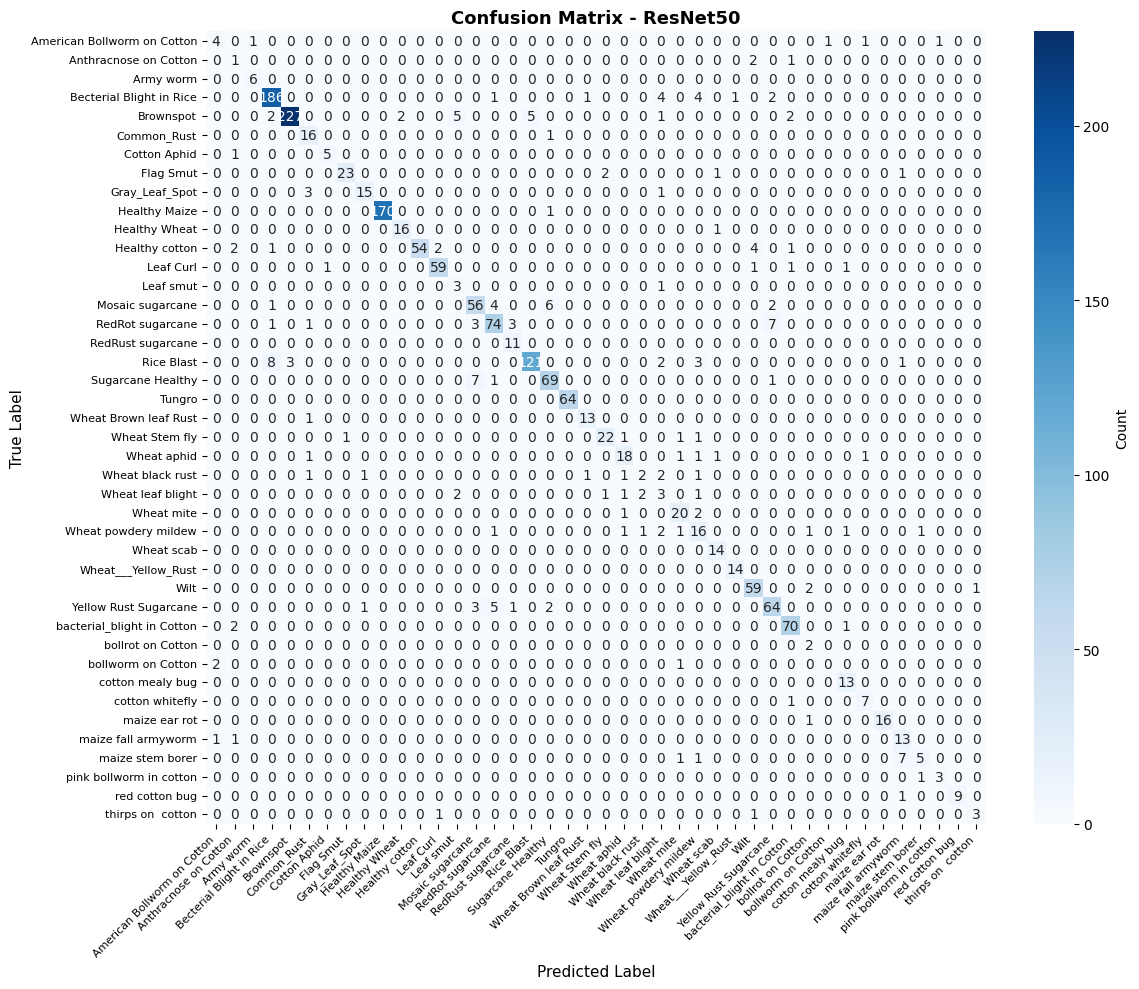

In [70]:
plot_confusion_matrix(y_test, y_test_pred_dl, classes, title='Confusion Matrix - ResNet50', filename='confusion_matrix_resnet50.png')

======================================================================<br>
SAVING ALL MODELS AND PROJECT FILES<br>
======================================================================

In [71]:
print("\n" + "="*70)
print("FINAL MODEL COMPARISON (Test Set)")
print("="*70)


FINAL MODEL COMPARISON (Test Set)


We use validation acc for ML models (except voting) as proxy, unless we run them on X_test (which is fast, let's do it)

In [72]:
test_acc_lr = accuracy_score(y_test, lr_model.predict(X_test_scaled))
test_acc_rf = accuracy_score(y_test, rf_model.predict(X_test_scaled))
test_acc_gb = accuracy_score(y_test, gb_model.predict(X_test_scaled))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.1s finished


In [74]:
results = {
    'Logistic Regression': test_acc_lr,
    'Random Forest': test_acc_rf,
    'Gradient Boosting': test_acc_gb,
    'ResNet50 (Deep Learning)': test_acc_dl
}

In [75]:
for model_name, acc in results.items():
    print(f"{model_name:25s}: {acc:.4f} ({acc*100:.2f}%)")

Logistic Regression      : 0.4516 (45.16%)
Random Forest            : 0.8134 (81.34%)
Gradient Boosting        : 0.7719 (77.19%)
ResNet50 (Deep Learning) : 0.8908 (89.08%)


In [76]:
best_model_name = max(results, key=results.get)
best_accuracy = results[best_model_name]

In [77]:
print(f"\n🏆 BEST MODEL: {best_model_name} with {best_accuracy:.4f} accuracy")
print(f"   Target (>90%): {'✓ ACHIEVED!' if best_accuracy >= 0.9 else '✗ Not achieved'}")


🏆 BEST MODEL: ResNet50 (Deep Learning) with 0.8908 accuracy
   Target (>90%): ✗ Not achieved


In [78]:
print("\n" + "="*70)
print("SAVING ALL MODELS AND PROJECT FILES")
print("="*70)


SAVING ALL MODELS AND PROJECT FILES


Save all models

In [79]:
models_to_save = {
    'logistic_regression.pkl': lr_model,
    'random_forest.pkl': rf_model,
    'gradient_boosting.pkl': gb_model,
    'voting_ensemble.pkl': voting_clf,
    'feature_scaler.pkl': scaler
}

In [80]:
for filename, model in models_to_save.items():
    filepath = os.path.join('saved_models', filename)
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"✓ Saved: {filename}")

✓ Saved: logistic_regression.pkl
✓ Saved: random_forest.pkl
✓ Saved: gradient_boosting.pkl
✓ Saved: voting_ensemble.pkl
✓ Saved: feature_scaler.pkl


Save DL model

In [81]:
dl_model.save('saved_models/resnet50_model.h5')
print(f"✓ Saved: resnet50_model.h5")

✓ Saved: resnet50_model.h5


Save Metadata

In [83]:
metadata = {
    'project': 'AI-Driven Crop Disease Prediction & Management System',
    'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'classes': classes,
    'n_classes': CONFIG['N_CLASSES'],
    'img_size': CONFIG['IMG_SIZE'],
    'model_test_accuracies': results,
    'best_model': {
        'name': best_model_name,
        'accuracy': best_accuracy,
        'target_achieved': bool(best_accuracy >= 0.9)
    },
    'dataset_info': {
        'total_images': len(X),
        'train_size': len(X_train),
        'val_size': len(X_val),
        'test_size': len(X_test)
    }
}

In [84]:
with open('saved_models/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

In [85]:
print(f"✓ Saved: metadata.json")

✓ Saved: metadata.json


Save Disease Recommendations (Comprehensive)

In [86]:
disease_recommendations = {}

In [87]:
for class_name in classes:
    disease_display = class_name.replace('_', ' ').title()
    crop = disease_display.split()[0] if ' ' in disease_display else "Crop"
    
    disease_recommendations[class_name] = {
        "disease_name": disease_display,
        "crop_type": crop,
        "description": f"A common disease affecting {crop} plants, identifiable by specific symptoms on plant tissues.",
        "symptoms": [
            "Discoloration or unusual spots on leaves",
            "Abnormal growth patterns or deformities",
            "Wilting despite adequate watering",
            "Visible lesions, pustules, or fungal growth"
        ],
        "management_steps": [
            "Remove and destroy all infected plant materials immediately",
            "Apply appropriate fungicide or pesticide (consult local agricultural extension)",
            "Improve air circulation by proper plant spacing (minimum 18-24 inches)",
            "Implement drip irrigation to avoid wetting foliage",
            "Monitor surrounding plants daily for early detection"
        ],
        "prevention": [
            "Use certified disease-free seeds or transplants",
            "Practice 3-4 year crop rotation",
            "Maintain field sanitation and remove crop debris",
            "Avoid working in fields when plants are wet",
            "Apply preventive fungicides before disease onset"
        ],
        "chemical_control": "Consult local agricultural extension for region-specific approved fungicides/pesticides",
        "organic_alternatives": [
            "Neem oil spray (2% solution)",
            "Copper-based fungicides",
            "Beneficial microorganisms (Trichoderma, Bacillus)",
            "Sulfur dust applications",
            "Compost tea foliar spray"
        ],
        "severity": "Moderate to High",
        "economic_impact": "Can cause 15-50% yield loss if untreated",
        "action_timeline": "Address within 1-2 weeks of detection",
        "expert_consultation": "Contact agricultural extension officer for severe outbreaks"
    }

In [88]:
with open('saved_models/disease_recommendations.json', 'w') as f:
    json.dump(disease_recommendations, f, indent=2)

In [89]:
print(f"✓ Saved: disease_recommendations.json")

✓ Saved: disease_recommendations.json


In [90]:
print("\n" + "="*70)
print("📦 ALL MODELS SAVED SUCCESSFULLY")
print("="*70)


📦 ALL MODELS SAVED SUCCESSFULLY
